**<center><font size=5>VGG-16 Modelini Kullanarak Beyin Tümörü Hesaplama</font></center>**
***


# <a id='intro'>1. Projeye Genel Bakış ve Hedefler</a>

Projenin genel amacı MR görüntülerini kullanarak tümör var veya tümör yok olarak mr görütülerinin sınıflandırılmasını sağlamak. kullanılan model [VGG-16](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection) VGG-16 önceden eğitilmiş model kullanılarak Tümör algılama CNN modelimiz eğitilir.. 

$\textrm{Accuracy} = \frac{\textrm{Number of correclty predicted images}}{\textrm{Total number of tested images}} \times 100\%$

Final Sonuçları
| Set | Accuracy |
|:-:|:-:|
| Validation Set* | ~95% |
| Test Set* | ~93% |
<br>


## <a id='dataset'>1.1. Veri Seti Hakkındaki Açıklamalar</a>

Veri Setini bu verisetini  [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection). ve [Brain Tumor Classification (MRI)](https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri/activity) verisetlerindeki benzer resimleri kullanarak yeni bir veri seti oluşturdum

* `NO` -  `0` olarak kodlandı (Tümör Yok)
* `YES` -  `1` olarak kodlandı (Tümör Var

MR görüntüleri hakkında kullanılan verisetinde yeterli bilgiler mevcut değildir.



# <a id='env'>2. Gerekli Ortamların Kurulması</a>

In [45]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [46]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

Bütün görüntü dosyalarımız bir klasörün içinde bu klasörün içinde  `yes` ve `no` adlı iki alt klasör bulunuyor. Bu klasörlerdeki verileri kullanarak `train`, `val` ve `test` klasörlerini oluşturacağım

In [47]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

9 directories


In [48]:
IMG_PATH = '../input/braintumor/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 50:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

# <a id='import'>3. Verilerin Yüklenmesi ve Önişlemlerin Uygulanması</a>

In [49]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [50]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

  0%|          | 0/2 [00:00<?, ?it/s]

815 images loaded from TRAIN/ directory.
100 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

227 images loaded from VAL/ directory.


In [51]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Eğitim Verisi', 'Doğrulama Verisi', 'Test Verisi'],
    y=y[0],
    name='Hayır',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Eğitim Verisi', 'Doğrulama Verisi', 'Test Verisi'],
    y=y[1],
    name='Evet',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Her Setteki Sınıfların Sayısı',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Sayı'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [52]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

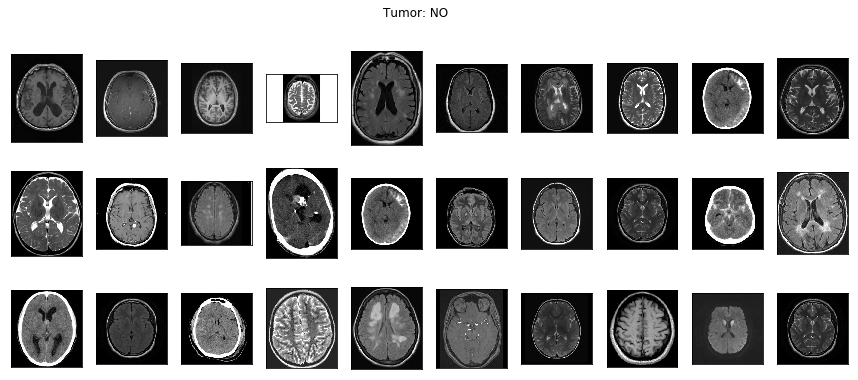

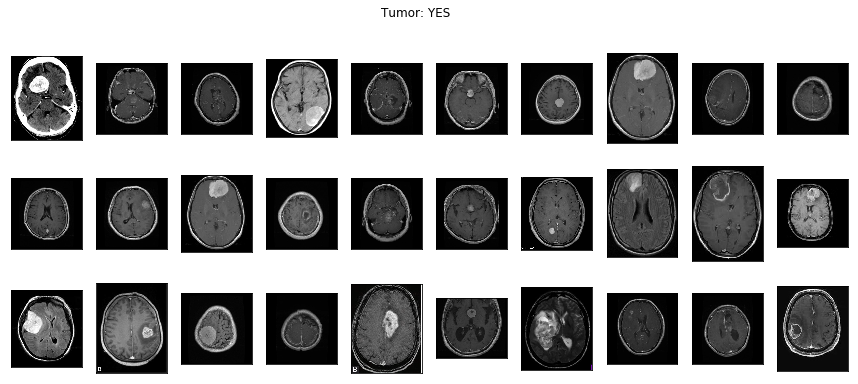

In [53]:
plot_samples(X_train, y_train, labels, 30)

Gördüğünüz gibi, resimler farklı 'genişlik' ve 'yükseklik' e ve farklı 'siyah köşelere' sahiptir. VGG-16 imput katmanı için görüntü boyutu `(224,224) '' olduğundan, bazı geniş görüntüler yeniden boyutlandırıldıktan sonra tuhaf görünebilir. Oran dağılımlarının histogramı ('oran = genişlik / yükseklik`):

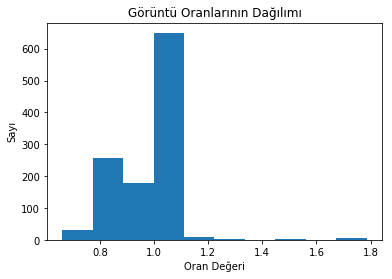

In [54]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Görüntü Oranlarının Dağılımı')
plt.xlabel('Oran Değeri')
plt.ylabel('Sayı')
plt.show()

Normalleştirmenin ilk adımı beyni görüntülerden ayırmak olacaktır.Normalleştirme için aşağıdaki tekniği uyguladım [pyimagesearch](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [55]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

Yukarıdaki fonksiyonun neler yapacağı ile ilgili bir örnek

In [56]:
img = cv2.imread('../input/braintumor/brain_tumor_dataset/yes/Y1714.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

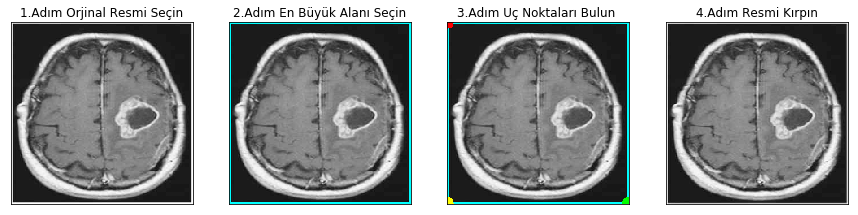

In [57]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('1.Adım Orjinal Resmi Seçin')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('2.Adım En Büyük Alanı Seçin')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('3.Adım Uç Noktaları Bulun ')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('4.Adım Resmi Kırpın')
plt.show()

In [58]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

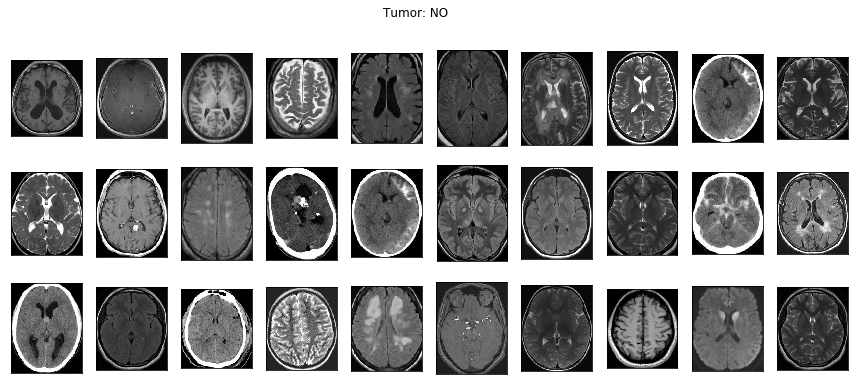

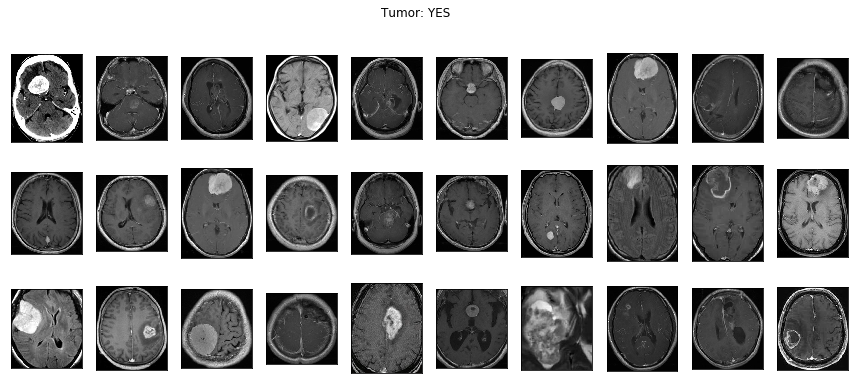

In [59]:
plot_samples(X_train_crop, y_train, labels, 30)

In [60]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [61]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

Bir sonraki adım, görüntüleri '' (224,224) '' olarak yeniden boyutlandırmak ve VGG-16 model girişi için gereken ön işlemeyi uygulamak olacaktır.

In [62]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [63]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [64]:
# plot_samples(X_train_prep, y_train, labels, 30)

# <a id='cnn'>4. CNN Model</a>

 Temel model olarak VGG-16 mimarisi ve ağırlıkları ile [Transfer Learning](https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e) mimarisini kullandım .

## <a id='aug'>4.1. Data Augmentation</a>

Küçük veri kümem olduğu için  [Data Augmentation] adı verilen tekniği kullandım(https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) Eğitim setinin boyutunu 'büyütmeye' yardımcı olur.

### <a id='demo'>4.1.1. Örnek</a>

Bu, arttırılmış görüntülerin nasıl göründüğü hakkındaki örnek görüntüdür.

In [65]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [66]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

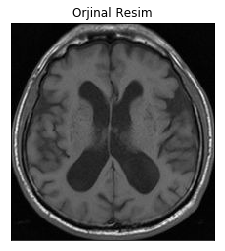

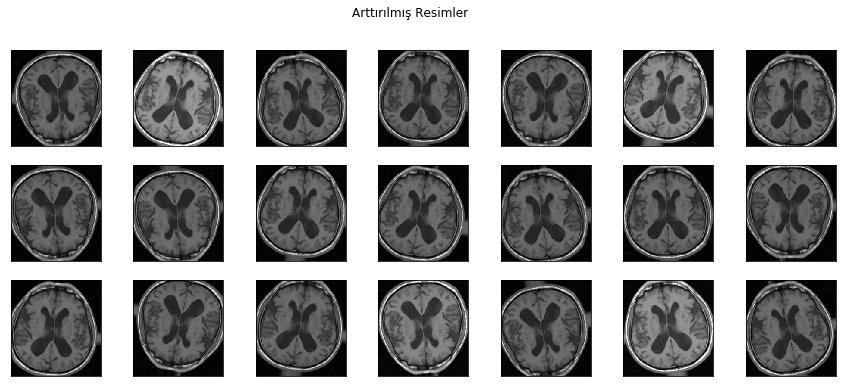

In [67]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Orjinal Resim')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Arttırılmış Resimler')
plt.show()

In [68]:
!rm -rf preview/

### <a id='apply'>4.1.2. Kırpma İşlemlerinin Uygulanması</a>

In [69]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 815 images belonging to 2 classes.
Found 227 images belonging to 2 classes.


## <a id='build'>4.2. VGG-16 Modelinin Kurulması</a>

In [70]:
# load base model
vgg16_weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [71]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [72]:
EPOCHS = 26
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=120,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[es]
)

Epoch 1/26
120/120 [==============================] - 65s 539ms/step - loss: 2.6331 - acc: 0.7139 - val_loss: 1.2987 - val_acc: 0.8187
Epoch 2/26
120/120 [==============================] - 62s 517ms/step - loss: 1.5817 - acc: 0.8177 - val_loss: 0.9211 - val_acc: 0.8620
Epoch 3/26
120/120 [==============================] - 63s 524ms/step - loss: 1.4068 - acc: 0.8479 - val_loss: 0.8465 - val_acc: 0.8703
Epoch 4/26
120/120 [==============================] - 63s 528ms/step - loss: 1.1718 - acc: 0.8603 - val_loss: 0.7509 - val_acc: 0.8817
Epoch 5/26
120/120 [==============================] - 63s 526ms/step - loss: 0.9490 - acc: 0.8851 - val_loss: 1.0717 - val_acc: 0.8712
Epoch 6/26
120/120 [==============================] - 63s 522ms/step - loss: 0.9182 - acc: 0.8877 - val_loss: 0.7703 - val_acc: 0.8864
Epoch 7/26
120/120 [==============================] - 64s 530ms/step - loss: 0.8069 - acc: 0.8998 - val_loss: 0.7662 - val_acc: 0.8909
Epoch 8/26
120/120 [==============================] - 6

 ## <a id='build'>4.3. Metriklerin Hesaplanması</a>

In [73]:
# validate on val set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = model.evaluate(X_val_prep, y_val, verbose=0)
_, test_acc = model.evaluate(X_test_prep, y_test, verbose=0)

In [74]:
history_1= history

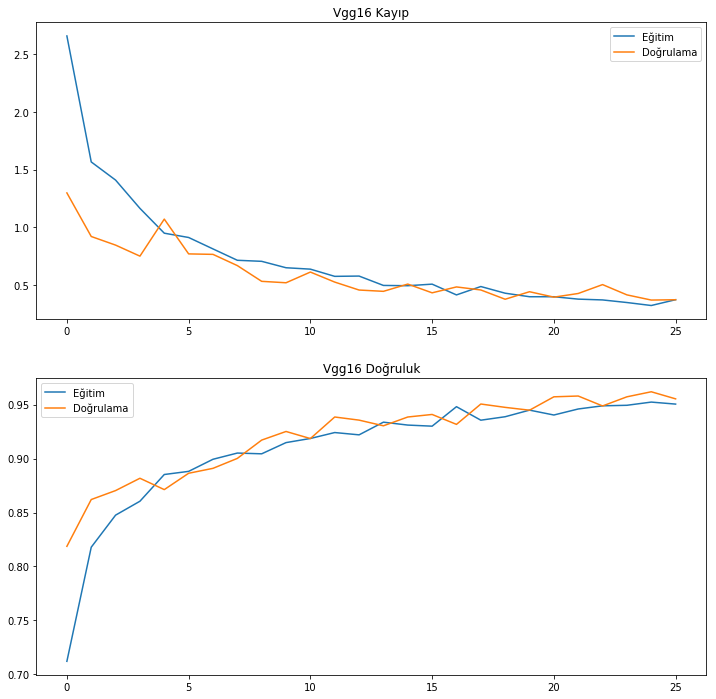

In [75]:
import sys
from matplotlib import pyplot
import matplotlib.pyplot as plt
pyplot.figure(figsize=(12,12))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Vgg16 Kayıp')
pyplot.plot(history.history['loss'], label='Eğitim')
pyplot.plot(history.history['val_loss'], label='Doğrulama')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Vgg16 Doğruluk')
pyplot.plot(history.history['acc'], label='Eğitim')
pyplot.plot(history.history['val_acc'], label='Doğrulama')
pyplot.legend()
pyplot.show()

In [76]:
print('Eğitim Verisi: %.3f, Test Verisi: %.3f' % (train_acc, test_acc))

Eğitim Verisi: 0.952, Test Verisi: 0.930


In [77]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predictions)
print('Doğruluk: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Kesinlik: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Duyarlılık: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 Skoru: %f' % f1)

Doğruluk: 0.930000
Kesinlik: 0.938776
Duyarlılık: 0.920000
F1 Skoru: 0.929293


In [78]:
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)

Cohens kappa: 0.860000
ROC AUC: 0.930000
[[47  3]
 [ 4 46]]


## <a id='perf'>4.4. Model Performansı</a>

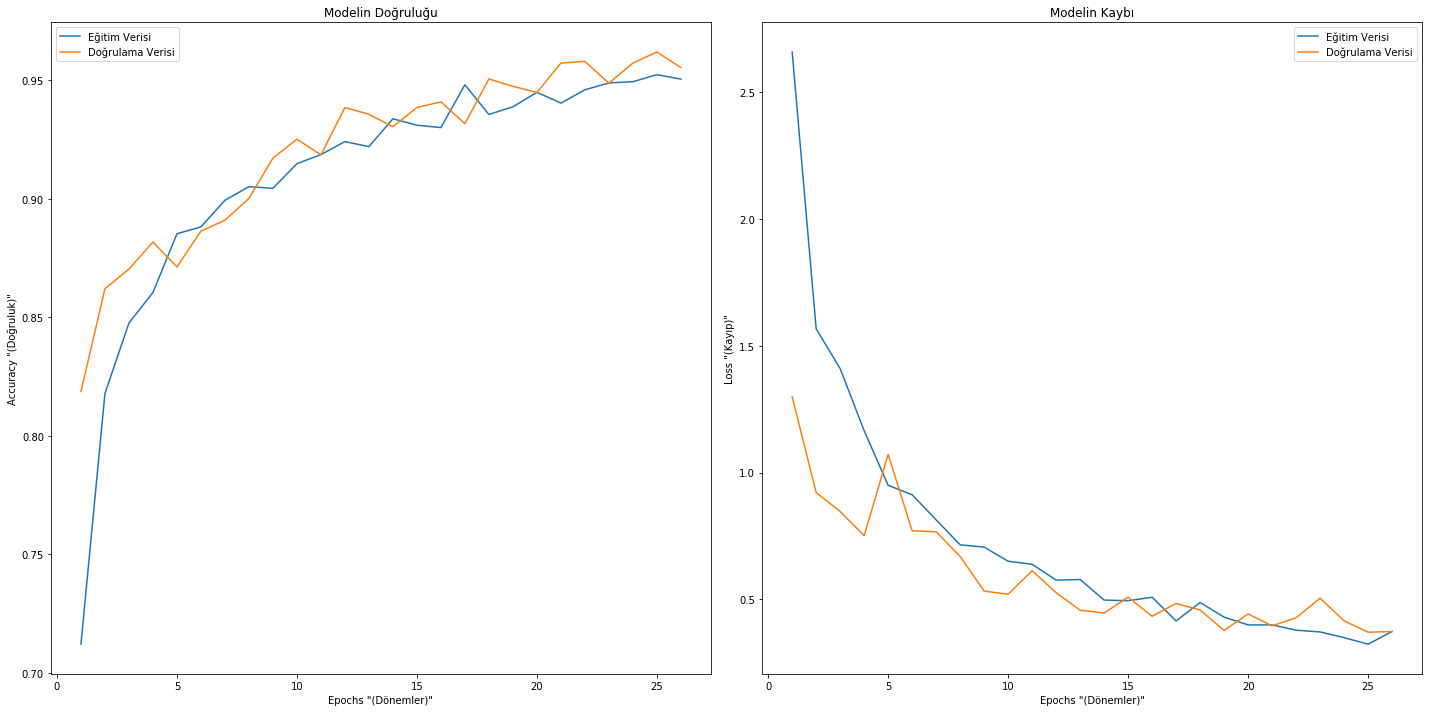

In [79]:
# plot model performance
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Verisi')
plt.plot(epochs_range, val_acc, label='Doğrulama Verisi')
plt.legend(loc="best")
plt.xlabel('Epochs "(Dönemler)"')
plt.ylabel('Accuracy "(Doğruluk)"')
plt.title('Modelin Doğruluğu')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Verisi')
plt.plot(epochs_range, val_loss, label='Doğrulama Verisi')
plt.legend(loc="best")
plt.xlabel('Epochs "(Dönemler)"')
plt.ylabel('Loss "(Kayıp)"')
plt.title('Modelin Kaybı')

plt.tight_layout()
plt.show()

Doğrulama Verisi  Accuracy"(Doğruluğu)" = 0.95


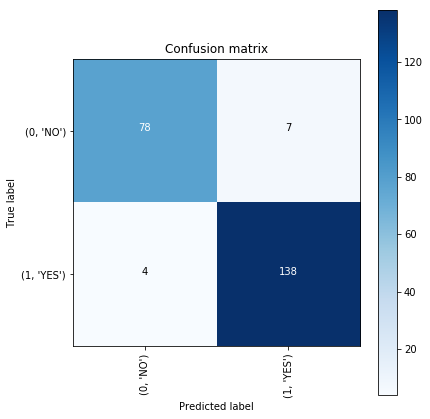

In [80]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Doğrulama Verisi  Accuracy"(Doğruluğu)" = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Verisi  Accuracy"(Doğruluğu)" = 0.93


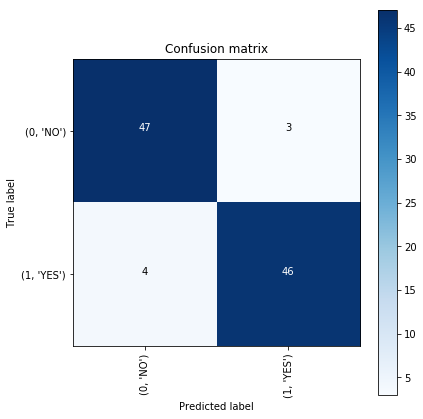

In [81]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Verisi  Accuracy"(Doğruluğu)" = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Şimdi test setinden yanlış sınıflandırılan MR görüntülerine bakalım

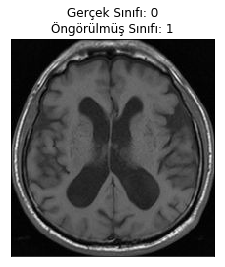

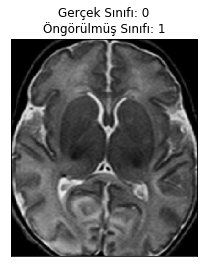

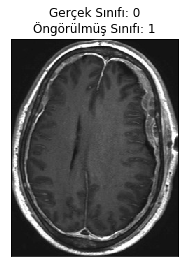

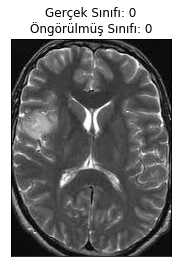

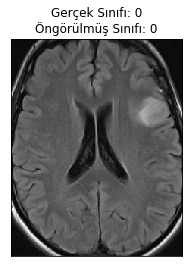

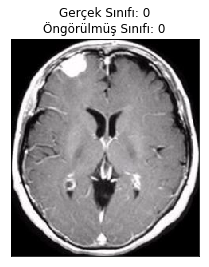

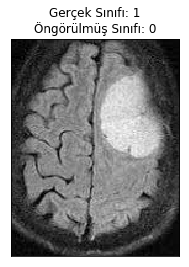

In [82]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('Yanlış Sınıflandırılmış Resim Yok.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Gerçek Sınıfı: {y_val[i]}\nÖngörülmüş Sınıfı: {predictions[i]}')
        plt.show()

# <a id='concl'>5. Modelin Kaydedilmesi</a>



In [83]:
# oluşturulan dosyaların silinmesi
!rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP
# Modelin kaydedilmesi
model.save('VGG_model.h5')